In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import logging
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from torch import optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from utils.modules import *
from utils.helper import *
# from torch.utils.tensorboard import SummaryWriter
from utils.paths import ROOT, DATA_DIR, RAW_DIR, PROCESSED_DIR, EQUITY_DIR

## Preprocess data

#### Read a CSV file

In [2]:
pth = os.path.join(EQUITY_DIR, "1d", "AAPL.csv")
cols = ["Date", "Close", "High", "Low", "Open", "Volume"]

df = pd.read_csv(pth, skiprows=2)
df.columns = cols

# Covert from Date feature as index of dataframe
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

# Display
df.head(5)

,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,24.261047,24.729270,23.821672,24.718174,212818400
2015-01-05,23.577574,24.110150,23.391173,24.030263,257142000
2015-01-06,23.579794,23.839424,23.218085,23.641928,263188400
2015-01-07,23.910433,24.010290,23.677430,23.788384,160423600
2015-01-08,24.829119,24.886815,24.121236,24.238848,237458000


<Axes: xlabel='Date'>

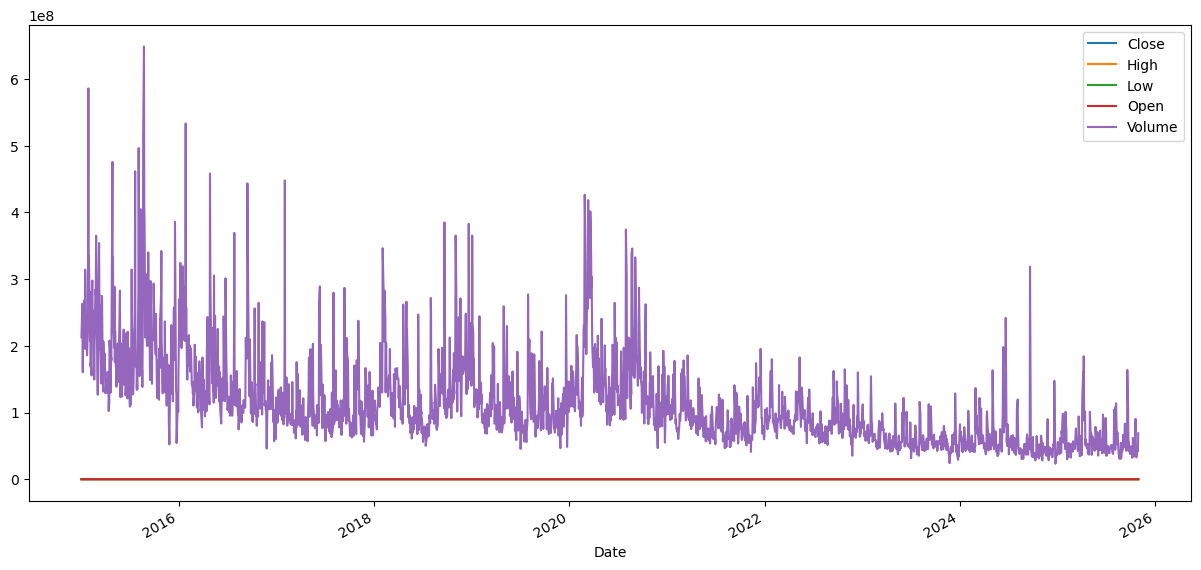

In [3]:
df.plot(figsize=(15, 7))

In [4]:
# tf means time frame or time range
cols_mask = ["Close", "Volume"]
tf_mask = (df.index >= dt.datetime(2020, 1, 1)) & (df.index <= dt.datetime(2025, 12, 31))

mh_df = df[cols_mask]
mh_df = mh_df.iloc[tf_mask]

mh_df.head(5)

,Close,Volume
Date,,
2020-01-02,72.538536,135480400
2020-01-03,71.833290,146322800
2020-01-06,72.405701,118387200
2020-01-07,72.065147,108872000
2020-01-08,73.224419,132079200


#### Time Bars
$\large r_t = \ln\left(\frac{P_{\text{Close},t}}{P_{\text{Close},t-1}}\right)$

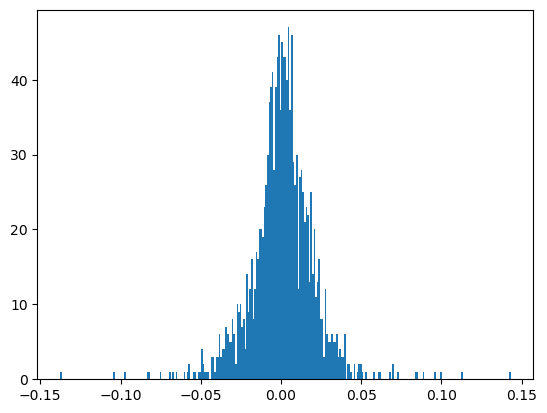

In [5]:
time_bars_price = mh_df.copy()
time_bars = np.log(time_bars_price["Close"] / time_bars_price["Close"].shift(1)).dropna()

bin_len = 0.001 # means size = 0.1%
plt.hist(time_bars, bins=np.arange(min(time_bars), max(time_bars) + bin_len, bin_len))
plt.show()

## Diffusion Model

### DDPM
* Variance: $\beta_t = \beta_{\text{start}} + (t-1) \frac{\beta_{\text{end}} - \beta_{\text{start}}}{T-1} \quad \text{for} \quad t = 1, \ldots, T$
* Noise: $\alpha = 1 - \beta$
* The cumulative product of all $\alpha$ up to $t$: $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$

#### Forward Process: 
* $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$
* $\epsilon$ (noise)
<br>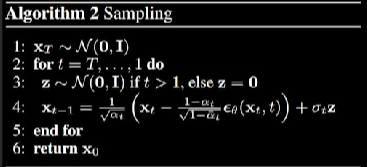

#### Reverse Process:
* $x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right) + \sqrt{\beta_t} z$
<br>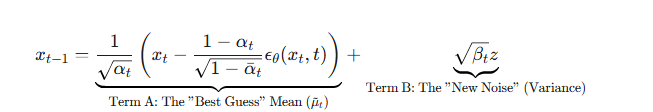
<br>
What is [:, None, None, None]? <br>
This is a "technique" of dimensionality expansion. $t$ is just a number (1D), but $x$ is an image (4D: Batch, Channel, H, W).None will expand the dimensionality of $\sqrt{\bar{\alpha}_t}$ from (Batch,) to (Batch, 1, 1, 1) so that it can be "multiplied" (broadcast) correctly with the image tensors (Batch, 3, 256, 256).

In [6]:
# logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

# class Diffusion:
#     def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, length=256, num_features=2, device="cuda"):
#         self.noise_steps = noise_steps
#         self.beta_start = beta_start
#         self.beta_end = beta_end
#         self.length = length
#         self.device = device

#         # Must Specifice number of features.
#         self.num_features = num_features

#         self.beta = self.prepare_noise_schedule().to(device)
#         self.alpha = 1 - self.beta
#         self.alpha_hat = torch.cumprod(self.alpha, dim=0)

#     def prepare_noise_schedule(self):
#         # numpy.linspace(start, stop, num) such as numpy.linspace(0, 10, 5) -> [0.0,2.5,5.0,7.5,10.0]
#         return torch.linspace(self.beta_start, self.beta_end, self.noise_steps) 

#     def noise(self, x, t):
#         # Reshape Batch -> (N,....)?  
#         sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None]
#         sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[i])[:, None, None]
#         E = torch.randn_like(x)
#         return (sqrt_alpha_hat * x) + (sqrt_one_minus_alpha_hat * E), E

#     def sample_timesteps(self, n):
#         # low = 1 if high = 1000 rand values between -1 to 999
#         return torch.randint(low=1, high=self.noise_steps, size=(n,))

#     def sample(self, model, n):
#         logging.info(f"Sampling {n} new images....")
#         model.eval()
#         with torch.no_grad():
#             # x = torch.rand( (n, self.length, self.num_features)).to(self.device)
#             x = torch.rand((n, self.num_features, self.length)) # [B, C, L]
#             for i in tdqm(reversed(range(1, self.noise_steps)), position=0):
#                 t = (torch.ones(n) * i).long().to(self.device)
#                 predicted_noise = model(x, t)
#                 alpha = self.alpha[t][:, None, None, None]
#                 alpha_hat = self.alpha_hat[t][:, None, None, None]
#                 beta = self.beta[t][:, None, None, None]
#                 if i > 1:
#                     noise = torch.randn_like(x)
#                 else:
#                     noise = torch.zeros_like(x)
#                 x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
#         model.train()
#         # For image processing
#         # x = (x.clamp(-1, 1) + 1) / 2
#         # x = (x * 255).type(torch.uint8)
#         return x

In [7]:
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

class Diffusion:
    # (init, prepare_noise_schedule, sample_timesteps ... เหมือนเดิมเป๊ะ ...
    #  ... แต่คุณต้อง "แก้" init ให้รับ args.window_size, args.num_features ...)
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, 
                 window_size=60, num_features=8, device="cuda"): # <-- [FIX] รับ L และ C
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.window_size = window_size   # (L)
        self.num_features = num_features # (C)
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1 - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps) 

    def noise(self, x, t):
        # x shape is [B, C, L]
        # We need to reshape alpha_hats to [B, 1, 1] to broadcast
        
        # [BUG FIX] (i -> t) and (:,None,None,None -> :,None,None)
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None] 
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None]
        
        E = torch.randn_like(x) # E is shape [B, C, L]
        # (This multiplication now works: [B, 1, 1] * [B, C, L])
        return (sqrt_alpha_hat * x) + (sqrt_one_minus_alpha_hat * E), E

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n):
        logging.info(f"Sampling {n} new 1D samples....")
        model.eval()
        with torch.no_grad():
            
            # [BUG FIX] Create noise in the correct [B, C, L] shape
            x = torch.rand((n, self.num_features, self.window_size)).to(self.device)
            
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                
                # [BUG FIX] Reshape alphas to [B, 1, 1] (for 1D)
                alpha = self.alpha[t][:, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None]
                beta = self.beta[t][:, None, None]
                
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                
                # (The math is the same, just the shapes are fixed)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        # [FIX] We don't clamp/save as images, we just return the raw tensor
        return x

In [8]:
def train(args, dataloader):
    # (setup_logging(args.run_name) ... )
    device = args.device
    
    # --- [BUG FIX] ---
    # เรา "ต้อง" ส่ง 'c_in' (num_features) และ 'c_out' ให้ UNet
    # (ผมเดาว่า U-Net ของคุณรับ... c_in, c_out ... นะ?)
    model = UNet(c_in=args.num_features, c_out=args.num_features).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=args.lr) # (args.lr ต้องมี!)
    mse = nn.MSELoss()
    
    # --- [BUG FIX] ---
    # เรียก Diffusion 1D (ที่เราเพิ่งแก้)
    diffusion = Diffusion(
        noise_steps=1000, # (คุณอาจจะอยากเพิ่ม 'args.noise_steps')
        window_size=args.window_size,
        num_features=args.num_features,
        device=device
    )
    
    # (logger = SummaryWriter(...) )
    l = len(dataloader)
    all_epoch_avg_losses = []
    # New Directory
    model_save_dir = os.path.join("models", args.run_name)
    results_save_dir = os.path.join("results", args.run_name)

    os.makedirs(model_save_dir, exist_ok=True)
    os.makedirs(results_save_dir, exist_ok=True)

    # [FIX 2] "สร้าง" (Define) "ขอบเขต" (Limits) "นอก" (Outside) ลูป!
    plot_ymax = None # (เรา "ยัง" (Don't) "ไม่รู้" (Know) "เพดาน" (Ceiling) ... จนกว่า Epoch 0 จะ "จบ" (Finish))
    plot_ymin = 1e-6 # (เรา "เดา" (Guess) "พื้น" (Floor) "เป้าหมาย" (Target) ... เช่น 1e-6)
    
    for epoch in range(args.epochs):
        logging.info(f"Starting epoch {epoch}:")
        pbar = tqdm(dataloader)
        epoch_loss_sum = 0.0
        
        # --- [BUG FIX] ---
        # (images, _) -> data (คุณแก้แล้ว... เยี่ยม!)
        for i, data in enumerate(pbar):
            # 1. data ที่ DataLoader "คาย" ออกมา... คือ [B, C, L]
            data = data.to(device) 
            
            # --- [BUG FIX] ---
            # (images.shape[0] -> data.shape[0])
            t = diffusion.sample_timesteps(data.shape[0]).to(device)
            
            # 2. "เติม" noise (ด้วย 'noise' 1D ที่แก้แล้ว)
            # x_t (L=60), noise (L=60)
            x_t, noise = diffusion.noise(data, t)
            
            # 3. "ทำนาย" (ด้วย U-Net 1D ที่คุณ "ซ่อน" ไว้)
            # predicted_noise (L=56)
            predicted_noise = model(x_t, t)
            
            # 4. "คำนวณ" Loss
            loss = mse(noise, predicted_noise)

            # (Optimizer steps... ถูกต้องแล้ว...)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix(MSE=loss.item())
            epoch_loss_sum += loss.item()
            
        # logger.add_scalar("MSE_Loss", loss.item(), global_step=epoch * l + i)
        avg_epoch_loss = epoch_loss_sum / l 
        all_epoch_avg_losses.append(avg_epoch_loss)

        # "คำนวณ" (Calculate) "เพดาน" (Y-Max) "ไดนามิก" (Dynamically)
        
        if epoch == 0:
            # "ครั้งแรก" (First time): "ตั้ง" (Set) "เพดาน" (Ceiling) ... "จาก" (Based on) Epoch 0
            plot_ymax = avg_epoch_loss * 1.1 # (คูณ "เผื่อ" (Padding) 10%)
        else:
            # "ครั้งต่อๆไป" (Later times): "ถ้า" (If) Loss มัน "พุ่ง" (Spike) "ทะลุ" (Above) เพดาน...
            # ... "อนุญาต" (Allow) ให้ "เพดาน" (Ceiling) "ขยับ" (Move) "ขึ้น" (Up) ...
            # ... (แต่ "ห้าม" (Never) "ขยับ" (Move) "ลง" (Down)! ... นี่คือ "หัวใจ" (Key)!)
            if avg_epoch_loss > (plot_ymax / 1.1): # (เช็ก "ค่า" (Value) "ก่อน" (Before) "เผื่อ")
                plot_ymax = avg_epoch_loss * 1.1

        loss_filename = f"loss_epoch_{epoch:04d}.png"
        save_loss_plot(all_epoch_avg_losses, 
                       os.path.join(results_save_dir, loss_filename),
                       total_epochs=args.epochs, # (ส่ง "เพดาน" (Limit) "แกน X")
                       y_axis_max=plot_ymax,       # (ส่ง "เพดาน" (Limit) "แกน Y")
                       y_axis_min=plot_ymin        # (ส่ง "พื้น" (Limit) "แกN Y")
                      )
        
        # (logger.add_scalar(...) )

        # --- [BUG FIX] ---
        # (images.shape[0] -> data.shape[0] ...
        #  ... แต่ 'data' มันคือ "ก้อนสุดท้าย"...
        #  ... ใช้ 'args.batch_size' (ถ้าคุณอยากสุ่ม 64) ดีกว่า)
        sampled_data = diffusion.sample(model, n=args.batch_size)
        
        # [FIX] เราไม่ 'save_images'... เราอาจจะ 'save_tensor'
        # (ผมจะข้ามการ "พล็อต" กราฟไปก่อน... มัน "รก" ครับ)
        # save_1d_plot(sampled_data, os.path.join("results", ...))
        # save_time_series_plots(sampled_data, os.path.join(results_save_dir, f"{epoch}.png"), num_plots=arg.batch_size)
        # Save x_0 (But predicted)
        save_time_series_plots(sampled_data, 
                               os.path.join(results_save_dir, f"epoch_{epoch}_x0_SAMPLE.png"), 
                               num_plots=4)
        # Save x_0 (Real Ground Truth)
        try:
            save_time_series_plots(data,
                                   os.path.join(results_save_dir, f"epoch_{epoch}_x0_REAL.png"), 
                                   num_plots=4)
        except Exception as e:
            logging.warning(f"Could not save x_0 REAL plot: {e}")
        # Save x_t (Noise)
        try:
            # (กันเหนียว... เผื่อ 'data' หาย)
            # สร้าง 't' ที่ "สูงสุด" (t=999) ... ขนาดเท่า 'data' (Batch จริง) ก้อนสุดท้าย
            max_t = (torch.ones(data.shape[0]) * (diffusion.noise_steps - 1)).long().to(device)
            # "เติม" Noise "เต็มขั้น"
            fully_noised_data, _ = diffusion.noise(data, max_t)
            save_time_series_plots(fully_noised_data, 
                                   os.path.join(results_save_dir, f"epoch_{epoch}_xt_NOISE.png"), 
                                   num_plots=4)
        except Exception as e:
            logging.warning(f"Could not save x_t noise plot: {e}")
        torch.save(model.state_dict(), os.path.join(model_save_dir, f"ckpt.pt"))

In [9]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size + 1

    def __getitem__(self, idx):
        # Shape: [window_size, NumFeatures] or [L, C]
        window = self.data[idx: idx + self.window_size]
        #  Conv1d U-Net expects shape: [C, L]
        #  we must  .T (Transpose) ... [L, C] -> [C, L]
        return window.T

In [10]:
 mh_df.shape[1]

2

In [11]:
from types import SimpleNamespace

def lanuch():
    # parser = argparse.ArgumentParser()
    # args = parser.parse_args()
    args = SimpleNamespace()
    args.run_name = "DDPM_Uncondtional"
    args.epochs = 500
    args.window_size = 256
    args.batch_size = 32
    args.device = "cuda"
    args.num_features = mh_df.shape[1]
    args.lr = 3e-4 # lr = learning rate = $3 \times 10^{-4}$ = 0.0003
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(mh_df)

    dataset = TimeSeriesDataset(scaled_data, args.window_size)
    dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

    first_batch = next(iter(dataloader))
    print(f"DataLoader created. First batch shape: {first_batch.shape}") # [B, C, L]

    train(args, dataloader)

In [12]:
# lanuch()

In [13]:
# tensorboard --logdir=runs

SyntaxError: cannot assign to expression here. Maybe you meant '==' instead of '='? (3224537314.py, line 1)

In [ ]:
def test(arg):
    model_save_dir = os.path.join("models", args.run_name)
    model = UNet(c_in=args.num_features, c_out=args.num_features).to(device)
    model.load_state_dict(torch.load( os.path.join(model_save_dir, "ckpt.pt") ))
    model.eval()